In [1]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "testing-framework"))

In [23]:
def compute_cdf_vals(r, beta, xs, use_matlab = True, debug = False):
    prior_cdf = np.zeros_like(xs)
    if use_matlab:
        if debug:
            for j in tqdm(range(len(xs))):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(xs[j]), nargout=1)
        else:
            for j, x in enumerate(xs):
                prior_cdf[j] = eng.compute_cdf_using_gengamma(float(r), float(beta), float(x), nargout=1)
    else:
        def gauss_density(z, x):
            return np.exp(-0.5 * (x/z)**2) / (np.sqrt(2*np.pi) * z)

        def gen_gamma_cdf(x):
            return prior_cdf.gammainc(beta, x**r)

        def integrand(z, x):
            return gauss_density(z, x) * (1 - gen_gamma_cdf((x/z)**2))
        
        for j, x in enumerate(xs):
            res = integrate.quad(integrand, 0, np.inf, args=(x,))[0]
            prior_cdf[j] = res
    return prior_cdf
    

In [24]:
def compute_prior_cdf_using_gamma_cdf(r, eta, n_samples=1000, tail_bound=0.001, tail_percent=0.1, scale=1, use_matlab=True, eng=eng, enforce_assert=True, return_assert=False, return_xs=False, debug=False):
    beta = (eta + 1.5) / r
    var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)
    
    cheby = np.sqrt(var_prior / tail_bound)
    if np.isnan(var_prior) or np.isinf(var_prior):
        cheby = 1e100
    x_max = min(99, cheby)
    n_tail = int(n_samples * tail_percent) if cheby >= 120 else 0

    if debug:
        print(f"Params: {r}, {eta}")
        print(f"Chebyshev bound: {cheby}")
        print(f"{'No tail' if n_tail == 0 else f'Tail samples: {n_tail}'}")

    xs_minus = np.concatenate((-np.logspace(np.log10(cheby), 2, n_tail),
                               np.linspace(-x_max, 0, n_samples//2-n_tail)))

    prior_cdf_minus = compute_cdf_vals(r, beta, xs_minus, use_matlab = use_matlab, debug = debug)

    if debug:
        print("Maximum Diff in y-values:", max(abs(np.diff(prior_cdf_minus))))
    if(max(abs(np.diff(prior_cdf_minus))) > 0.02 and eta < 0):
        
        while max(abs(np.diff(prior_cdf_minus))) > 0.02:
            filtered_y, idx = np.unique(prior_cdf_minus, return_index = True)
            filtered_x = xs_minus[idx]
            idx2 = filtered_y > 1e-15
            filtered_y = filtered_y[idx2]
            filtered_x = filtered_x[idx2]

            inv_linspline = interpolate.InterpolatedUnivariateSpline(x= filtered_y, y= filtered_x, k=1, ext='const')
            xs_add = inv_linspline(np.linspace(0, 0.5, n_samples//2))
            prior_cdf_add = compute_cdf_vals(r, beta, xs_add, use_matlab = use_matlab, debug = debug)

            xs_minus, idx_merge = np.unique(np.append(xs_minus, xs_add), return_index = True)
            prior_cdf_minus = np.sort(np.append(prior_cdf_minus, prior_cdf_add)[idx_merge])
            if debug:
                print("Maximum Diff in y-values with new points:", max(abs(np.diff(prior_cdf_minus))))

        
        
    xs_plus = -np.flip(xs_minus[:-1])
    prior_cdf_plus = 1-np.flip(prior_cdf_minus[:-1])

    xs = np.concatenate((xs_minus, xs_plus))
    prior_cdf = np.concatenate((prior_cdf_minus, prior_cdf_plus))

    if debug:
        print(f"First CDF value: {prior_cdf[0]}")
        print(f"Last CDF value: {prior_cdf[-1]}")
        print(f"Tail bound: {tail_bound}")

    if return_assert or enforce_assert:
        eps = tail_bound
        if not (-eps < prior_cdf[0] < eps and 1 - eps < prior_cdf[-1] < 1 + eps):
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("CDF bounds not satisfied")
        
    xs = np.concatenate(([1.01 * xs[0]], xs, [1.01 * xs[-1]]))
    prior_cdf = np.concatenate(([0], prior_cdf, [1]))
    cdf_spline = interpolate.InterpolatedUnivariateSpline(x=xs, y=prior_cdf, k=3, ext='const')

    if return_assert or enforce_assert:
        x = np.sort(sample_prior(r, eta, 10000))
        res = stats.ks_1samp(x, cdf_spline)
        if debug:
            print(res)
        if not 0 <= res.statistic <= 0.2:
            if return_assert:
                return (xs, None) if return_xs else None
            elif enforce_assert:
                raise AssertionError("KS test failed")

    return (xs, cdf_spline) if return_xs else cdf_spline

In [4]:
num_samples = 2000
xs, cdf = compute_prior_cdf_using_gamma_cdf(0.41, 5.6, n_samples=num_samples, tail_percent=.01, tail_bound= 1e-5, debug = True, use_matlab=True, eng = eng, return_xs = True)

Params: 0.41, 5.6
Chebyshev bound: 10753.73999905624
Tail samples: 20


100%|██████████| 1000/1000 [00:01<00:00, 520.19it/s]

Maximum Diff in y-values: 0.0036085728296606015
First CDF value: 0.0
Last CDF value: 1.0
Tail bound: 1e-05
KstestResult(statistic=0.01287378976639808, pvalue=0.07206259957793826, statistic_location=-2.5778430858113266, statistic_sign=1)


In [19]:
num_samples = 2000
xs, cdf = compute_prior_cdf_using_gamma_cdf(0.7, -1.3, n_samples=num_samples, tail_percent=.1, tail_bound= 0.0001, debug = True, use_matlab=True, eng = eng, return_xs = True)

Params: 0.7, -1.3
Chebyshev bound: 53.7979596021394
No tail


100%|██████████| 1000/1000 [00:01<00:00, 544.02it/s]


Maximum Diff in y-values: 0.22967925909739367


100%|██████████| 1000/1000 [00:01<00:00, 538.06it/s]


Maximum Diff in y-values with new points: 0.02181151261613712


100%|██████████| 1000/1000 [00:01<00:00, 536.00it/s]

Maximum Diff in y-values with new points: 0.004829885605780182
First CDF value: 1.3675910528521007e-19
Last CDF value: 1.0
Tail bound: 0.0001
KstestResult(statistic=0.01090982827554221, pvalue=0.18352624337829881, statistic_location=0.008563934653946455, statistic_sign=-1)


In [150]:
num_samples = 2000
xs, cdf = compute_prior_cdf_using_gamma_cdf(0.2, -1.4, n_samples=num_samples, tail_percent=.1, tail_bound= 0.0001, debug = True, use_matlab=True, eng = eng, return_xs = True)


Params: 0.2, -1.4
Chebyshev bound: 543.4266279821043
Tail samples: 200


100%|██████████| 1000/1000 [00:01<00:00, 615.36it/s]


Maximum Diff in y-values: 0.3526562508462122


100%|██████████| 1000/1000 [00:01<00:00, 654.69it/s]


Maximum Diff in y-values with new points: 0.11477273097619267


100%|██████████| 1000/1000 [00:01<00:00, 673.96it/s]


Maximum Diff in y-values with new points: 0.039332649151598176


100%|██████████| 1000/1000 [00:01<00:00, 674.66it/s]

Maximum Diff in y-values with new points: 0.016460724351531064
First CDF value: 1.2352968124844238e-06
Last CDF value: 0.9999987647031875
Tail bound: 0.0001
KstestResult(statistic=0.014219480759506964, pvalue=0.03472474628742295, statistic_location=1.7924366552651403e-09, statistic_sign=1)


In [107]:
num_samples = 2000
xs, cdf = compute_prior_cdf_using_gamma_cdf(1, -1, n_samples=num_samples, tail_percent=.1, tail_bound= 0.0001, debug = True, use_matlab=True, eng = eng, return_xs = True)

Params: 1, -1
Chebyshev bound: 70.71067811865476
No tail


100%|██████████| 1000/1000 [00:01<00:00, 529.46it/s]


Maximum Diff in y-values: 0.10899164277965956


100%|██████████| 1998/1998 [00:03<00:00, 589.64it/s]

Maximum Diff in y-values: 0.0012877300519729684
First CDF value: 9.422099208085137e-50
Last CDF value: 1.0
Tail bound: 0.0001
KstestResult(statistic=0.006284798475034381, pvalue=0.8220470013100174, statistic_location=0.3755609160691396, statistic_sign=1)


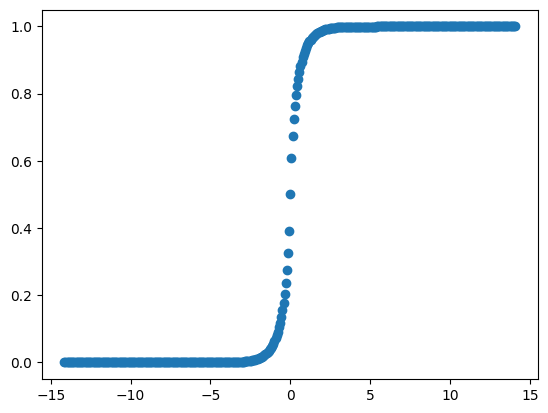

In [18]:
half_samples = num_samples // 2
mid = int(0.2*half_samples)
x = xs[half_samples - mid: half_samples + mid]
y = cdf(xs)[half_samples - mid: half_samples + mid]
plt.scatter(x, y)
plt.show()

linspline = interpolate.InterpolatedUnivariateSpline(x=x, y=y, k=3, ext='const')
invcdf = interpolate.InterpolatedUnivariateSpline(x=y, y=x, k=3, ext='const')

## Before

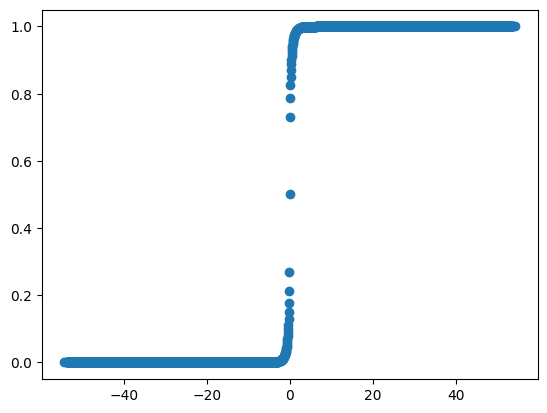

In [17]:
plt.scatter(xs, cdf(xs))
plt.show()

## After

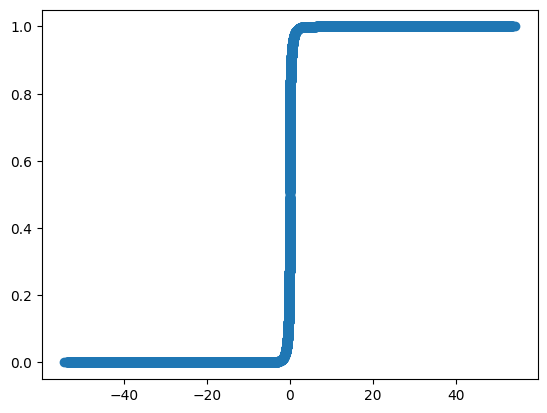

In [13]:
plt.scatter(xs, cdf(xs))
plt.show()

In [120]:
y_test = cdf(xs)
idx = y_test<1-1e-10
filtered_y = y_test[idx]
filttered_x = xs[idx]

linspline = interpolate.InterpolatedUnivariateSpline(x=filttered_x, y=filtered_y, k=3, ext='const')
invcdf = interpolate.InterpolatedUnivariateSpline(x=filtered_y, y=filttered_x, k=3, ext='const')

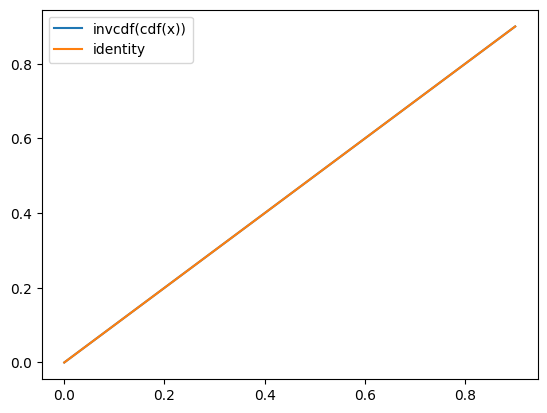

In [151]:
y_test = cdf(xs)
idx = y_test<1-1e-10
filtered_y = y_test[idx]
filttered_x = xs[idx]

linspline = interpolate.InterpolatedUnivariateSpline(x=filttered_x, y=filtered_y, k=3, ext='const')
invcdf = interpolate.InterpolatedUnivariateSpline(x=filtered_y, y=filttered_x, k=3, ext='const')

xx = np.arange(0, 1, 0.1)
yy = cdf(invcdf(xx))
plt.plot(xx, yy, label = "invcdf(cdf(x))")
plt.plot(xx, xx, label = 'identity')
plt.legend()

# Before

(-3.0, 3.0)

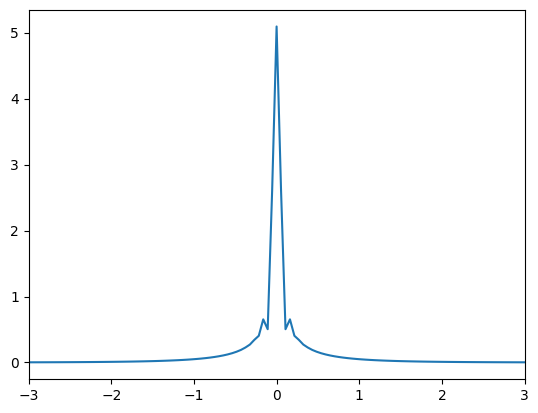

In [181]:
plt.plot(xs, cdf.derivative()(xs))
plt.xlim([-3, 3])

# After

(-5e-05, 5e-05)

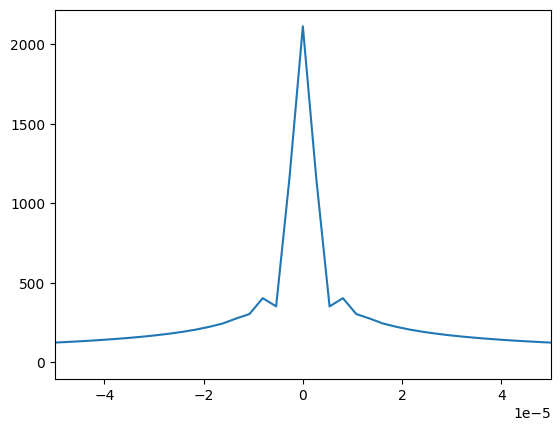

In [21]:
plt.plot(xs, cdf.derivative()(xs))
plt.xlim([-0.00005, 0.00005])

In [148]:
y = np.array([10, 13, 14, 18, 24, 25, 30])
cutoffs = np.append(True, np.diff(y) > 2)
y[cutoffs]

# Strategy: Find all diffs, filter and form array where diffs are greater than threshold
# Create linear interplant in those regions

array([10, 13, 18, 24, 30])